In [1]:
import warnings 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight') 
%matplotlib inline 
warnings.filterwarnings('ignore') 


In [2]:
train = pd.read_csv(r"D:\titanic dataset 2\train (1).csv") 
test = pd.read_csv(r"D:\titanic dataset 2\test (1).csv") 

# To know number of columns and rows 
train.shape 

(891, 12)

In [3]:
train.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
#to check null values
train.isnull().sum() 


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Visualization

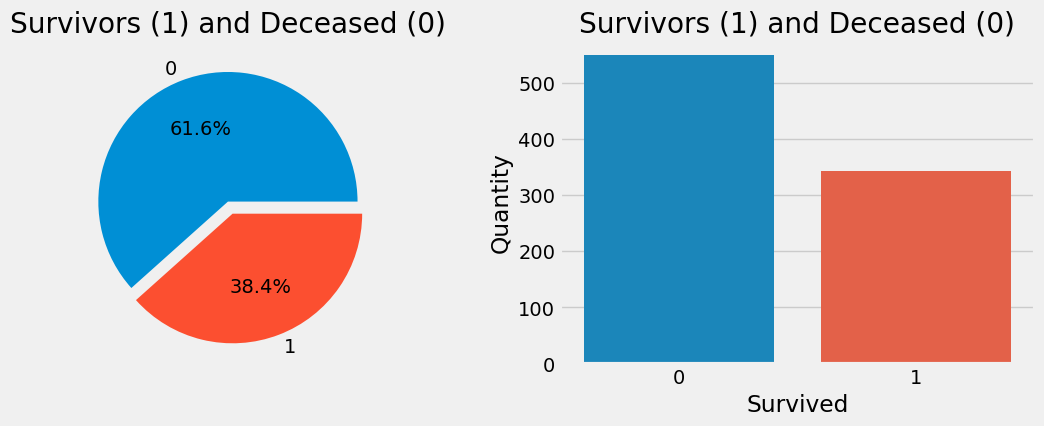

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train['Survived'].value_counts().plot.pie(
    explode=[0, 0.1],
    autopct='%1.1f%%',
    ax=axes[0],
    shadow=False
)
axes[0].set_title('Survivors (1) and Deceased (0)')
axes[0].set_ylabel('')

sns.countplot(x='Survived', data=train, ax=axes[1])  # Specify 'x' explicitly
axes[1].set_ylabel('Quantity')
axes[1].set_title('Survivors (1) and Deceased (0)')

plt.show()


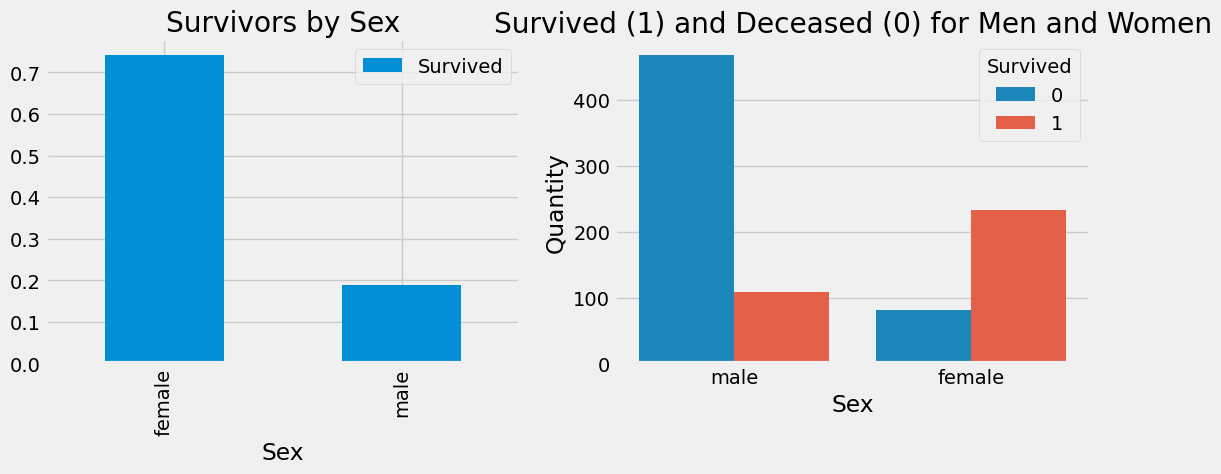

In [8]:


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=axes[0])
axes[0].set_title('Survivors by Sex')

sns.countplot(x='Sex', hue='Survived', data=train, ax=axes[1])
axes[1].set_ylabel('Quantity')
axes[1].set_title('Survived (1) and Deceased (0) for Men and Women')

plt.show()


# Feature Engineering

In [9]:
#let’s see which columns should we drop and/or modify for the model to predict the testing data. 
#The main tasks in this step is to drop unnecessary features and to convert string data into the numerical category 
#for easier training.

#We’ll start off by dropping the Cabin feature since not a lot more useful information can be extracted from it.
#But we will make a new column from the Cabins column to see if there was cabin information allotted or not.

In [10]:
# Create a new column 'CabinBool' indicating if the cabin value was provided or was NaN
train["CabinBool"] = (train["Cabin"].notnull().astype('int'))
test["CabinBool"] = (test["Cabin"].notnull().astype('int'))

# Remove the 'Cabin' column from the test and train datasets
train = train.drop(columns=['Cabin'])
test = test.drop(columns=['Cabin'])


In [12]:
#We can also drop the Ticket feature since it’s unlikely to yield any useful information
train = train.drop(['Ticket'], axis=1) 
test = test.drop(['Ticket'], axis=1) 


In [13]:
#There are missing values in the Embarked feature. For that, we will replace the NULL values with ‘S’ as the number of 
#Embarks for ‘S’ are higher than the other two.

# replacing the missing values in 
# the Embarked feature with S 
train = train.fillna({"Embarked": "S"}) 


In [14]:
#We will now sort the age into groups. We will combine the age groups of the people and categorize them into 
#the same groups. BY doing so we will be having fewer categories and will have a better prediction since it will be a 
#categorical dataset.

# Fill missing Age values with a placeholder and categorize ages into logical groups
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)

bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']

train['AgeGroup'] = pd.cut(train["Age"], bins, labels=labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels=labels)


In [15]:
#In the ‘title’ column for both the test and train set, we will categorize them into an equal number of classes. 
#Then we will assign numerical values to the title for convenience of model training.

# Create a combined group of both datasets
combine = [train, test]

# Extract a title for each Name in the train and test datasets
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

# Replace various titles with more common names
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(
        ['Lady', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'],
        'Rare')

    dataset['Title'] = dataset['Title'].replace(
        ['Countess', 'Lady', 'Sir'],
        'Royal')
    
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

# Map each of the title groups to a numerical value
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)


In [16]:
#Now using the title information we can fill in the missing age values.
mr_age = train[train["Title"] == 1]["AgeGroup"].mode() # Young Adult 
miss_age = train[train["Title"] == 2]["AgeGroup"].mode() # Student 
mrs_age = train[train["Title"] == 3]["AgeGroup"].mode() # Adult 
master_age = train[train["Title"] == 4]["AgeGroup"].mode() # Baby 
royal_age = train[train["Title"] == 5]["AgeGroup"].mode() # Adult 
rare_age = train[train["Title"] == 6]["AgeGroup"].mode() # Adult 

age_title_mapping = {1: "Young Adult", 2: "Student", 
					3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"} 

for x in range(len(train["AgeGroup"])): 
	if train["AgeGroup"][x] == "Unknown": 
		train["AgeGroup"][x] = age_title_mapping[train["Title"][x]] 

for x in range(len(test["AgeGroup"])): 
	if test["AgeGroup"][x] == "Unknown": 
		test["AgeGroup"][x] = age_title_mapping[test["Title"][x]] 


In [17]:
#Now assign a numerical value to each age category. Once we have mapped the age into different categories we do not 
#need the age feature. Hence drop it

# map each Age value to a numerical value 
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3, 
			'Student': 4, 'Young Adult': 5, 'Adult': 6, 
			'Senior': 7} 
train['AgeGroup'] = train['AgeGroup'].map(age_mapping) 
test['AgeGroup'] = test['AgeGroup'].map(age_mapping) 

train.head() 

# dropping the Age feature for now, might change 
train = train.drop(['Age'], axis=1) 
test = test.drop(['Age'], axis=1) 


In [18]:
#Drop the name feature since it contains no more useful information.
train = train.drop(['Name'], axis=1) 
test = test.drop(['Name'], axis=1) 


In [19]:
#Assign numerical values to sex and embarks categories\

sex_mapping = {"male": 0, "female": 1} 
train['Sex'] = train['Sex'].map(sex_mapping) 
test['Sex'] = test['Sex'].map(sex_mapping) 

embarked_mapping = {"S": 1, "C": 2, "Q": 3} 
train['Embarked'] = train['Embarked'].map(embarked_mapping) 
test['Embarked'] = test['Embarked'].map(embarked_mapping) 


In [20]:
#Fill in the missing Fare value in the test set based on the mean fare for that P-class
for x in range(len(test["Fare"])): 
	if pd.isnull(test["Fare"][x]): 
		pclass = test["Pclass"][x] # Pclass = 3 
		test["Fare"][x] = round( 
			train[train["Pclass"] == pclass]["Fare"].mean(), 4) 

# map Fare values into groups of 
# numerical values 
train['FareBand'] = pd.qcut(train['Fare'], 4, 
							labels=[1, 2, 3, 4]) 
test['FareBand'] = pd.qcut(test['Fare'], 4, 
						labels=[1, 2, 3, 4]) 

# drop Fare values 
train = train.drop(['Fare'], axis=1) 
test = test.drop(['Fare'], axis=1) 


# Model Training

In [21]:
#We will be using Random forest as the algorithm of choice to perform model training. Before that, we will split the data
#in an 80:20 ratio as a train-test split. For that, we will use the train_test_split() from the sklearn library.

from sklearn.model_selection import train_test_split 

# Drop the Survived and PassengerId 
# column from the trainset 
predictors = train.drop(['Survived', 'PassengerId'], axis=1) 
target = train["Survived"] 
x_train, x_val, y_train, y_val = train_test_split( 
	predictors, target, test_size=0.2, random_state=0) 


In [22]:
#Now import the random forest function from the ensemble module of sklearn and for the training set.
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score 

randomforest = RandomForestClassifier() 

# Fit the training data along with its output 
randomforest.fit(x_train, y_train) 
y_pred = randomforest.predict(x_val) 

# Find the accuracy score of the model 
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2) 
print(acc_randomforest) 


85.47


# Prediction

In [ ]:
ids = test['PassengerId'] 
predictions = randomforest.predict(test.drop('PassengerId', axis=1)) 

# set the output as a dataframe and convert 
# to csv file named resultfile.csv 
output = pd.DataFrame({'PassengerId': ids, 'Survived': predictions}) 
output.to_csv('resultfile.csv', index=False) 
